# Building The Search Engine!

I attended Dataquest's portfolio building webinars (this project was split into two parts). In order to venture out and begin dabbling with machine learning, I decided to step out of my comfort zone and make the time to search for and go to free tutorial webinars, or even follow tutorials on youtube to learn about machine learning concepts. I also tend to better grasp concepts if I have exposure with them, so tutorials have been a great motivator for me to follow thru on my educational goals. 

Goals of this project: Recommend books! :)
What we need: 
- List of books we like
- Data on book ratings
We can use data from Goodreads! Goodreads helps you keep track of books you've read 

Sources:
Data scraped by researchers at UCSD. Why? Well GoodReads doesn't have an API thats accessible, and it can be difficult to scrape due to the large data sets we will be working with (millions of ratings, etc)
Available at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home

Sources:
- Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18.  [bibtex]
- Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19. [bibtex]

book_id_map.csv:
- Helps us map between the book IDs in one data set and the other data set. It makes sure we are referring it to the same book across both data sets. 

goodreads_interactions.csv:
- Has 3 columns we care for: user_id (each unique id for each user on GR), book_id (unique id for each book on GR), ratings (books rated 1-5)

goodreads_books.json:
- Millions of lines of meta data

Project Steps:
1. Search for the books
    - We have to create a search engine!
2. Create a book list
3. Recommend Books
    - Finding all the users that liked the same books as us, and see what books THEY liked. 

In [1]:
# Command line utility that counts how many lines the file has. 
!wc -l goodreads_books.json.gz

 7588375 goodreads_books.json.gz


In [2]:
# It's so huge, and has the potential to expand as you work with it, so the best method is to have the file zipped. 
!ls -lh | grep goodreads_books.json.gz

-rw-r--r--  1 mellanyandrea  staff   1.9G Feb 24 21:16 goodreads_books.json.gz


In [3]:
# Streaming fashion: Reading line-by-line, instead of reading whole file into memory at once like in Pandas. 
import gzip

with gzip.open("goodreads_books.json.gz", 'r') as f:
    line = f.readline() # read a single line

In [4]:
# a single line of 1 single meta data of one book:
line

b'{"isbn": "0312853122", "text_reviews_count": "1", "series": [], "country_code": "US", "language_code": "", "popular_shelves": [{"count": "3", "name": "to-read"}, {"count": "1", "name": "p"}, {"count": "1", "name": "collection"}, {"count": "1", "name": "w-c-fields"}, {"count": "1", "name": "biography"}], "asin": "", "is_ebook": "false", "average_rating": "4.00", "kindle_asin": "", "similar_books": [], "description": "", "format": "Paperback", "link": "https://www.goodreads.com/book/show/5333265-w-c-fields", "authors": [{"author_id": "604031", "role": ""}], "publisher": "St. Martin\'s Press", "num_pages": "256", "publication_day": "1", "isbn13": "9780312853129", "publication_month": "9", "edition_information": "", "publication_year": "1984", "url": "https://www.goodreads.com/book/show/5333265-w-c-fields", "image_url": "https://images.gr-assets.com/books/1310220028m/5333265.jpg", "book_id": "5333265", "ratings_count": "3", "work_id": "5400751", "title": "W.C. Fields: A Life on Film", "t

In [5]:
import json

#load string method to access the python dictionary. 
json.loads(line)

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

In [6]:
# Takes a single line and only returns the fields we care about
def parse_fields(line):
    data = json.loads(line)
    return {
        "book_id": data["book_id"],
        "title": data["title_without_series"],
        "ratings": data["ratings_count"],
        "url": data["url"],
        "cover_image": data["image_url"]
    }

In [7]:
books_titles = []

# Only selecting some fields to use. We are also only using books in which there are more than 15 ratings for it. 
# Then it will be added to books_titles, allowing this list to actually fit. 

with gzip.open("goodreads_books.json.gz", "r") as f:
    while True:
        line = f.readline()
        if not line:
            break
        fields = parse_fields(line)
        # Trying to convert ratings into an integer! Have to make sure that it returns a ValueError to check. 
        try:
            ratings = int(fields["ratings"])
        except ValueError:
            continue
        if ratings > 15:
            books_titles.append(fields)

In [8]:
import pandas as pd

# Turning books_titles into a dataframe:
titles = pd.DataFrame.from_dict(books_titles)

In [9]:
# Ratings numerical column:
titles["ratings"] = pd.to_numeric(titles["ratings"])

How do we construct a search engine?

- With a search engine, we want to be able to minimize our search space as much as possible by minimizing the number of potential characters in each title. 

example:
"HARRY potter"
"harry POTTER"

If we don't do any processing, the search engine will treat each one differently even though they are technically the same.

In [10]:
# Creating a modificated title column to minimize the search space and potential characters, making the search
# engine more efficient

titles["mod_title"] = titles["title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)

In [11]:
titles

,book_id,title,ratings,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,The Unschooled Wizard Sun Wolf and Starhawk 12
1,6066819,Best Friends Forever,51184,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,Best Friends Forever
2,287141,The Aeneid for Boys and Girls,46,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,The Aeneid for Boys and Girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,98,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,Alls Fairy in Love and War Avalon Web of Magic 8
4,287149,The Devil's Notebook,986,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,The Devils Notebook
...,...,...,...,...,...,...
1308952,17805813,"Ondine (Ondine Quartet, #0.5)",327,https://www.goodreads.com/book/show/17805813-o...,https://images.gr-assets.com/books/1379766592m...,Ondine Ondine Quartet 05
1308953,331839,Jacqueline Kennedy Onassis: Friend of the Arts,18,https://www.goodreads.com/book/show/331839.Jac...,https://s.gr-assets.com/assets/nophoto/book/11...,Jacqueline Kennedy Onassis Friend of the Arts
1308954,2685097,The Spaniard's Blackmailed Bride,112,https://www.goodreads.com/book/show/2685097-th...,https://s.gr-assets.com/assets/nophoto/book/11...,The Spaniards Blackmailed Bride
1308955,2342551,The Children's Classic Poetry Collection,36,https://www.goodreads.com/book/show/2342551.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,The Childrens Classic Poetry Collection


In [12]:
# Lower casing it: 
titles["mod_title"] = titles["mod_title"].str.lower()

In [13]:
titles["mod_title"] = titles["mod_title"].str.replace("\s+", " ", regex=True)

In [14]:
titles

,book_id,title,ratings,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,51184,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,46,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,98,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,986,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook
...,...,...,...,...,...,...
1308952,17805813,"Ondine (Ondine Quartet, #0.5)",327,https://www.goodreads.com/book/show/17805813-o...,https://images.gr-assets.com/books/1379766592m...,ondine ondine quartet 05
1308953,331839,Jacqueline Kennedy Onassis: Friend of the Arts,18,https://www.goodreads.com/book/show/331839.Jac...,https://s.gr-assets.com/assets/nophoto/book/11...,jacqueline kennedy onassis friend of the arts
1308954,2685097,The Spaniard's Blackmailed Bride,112,https://www.goodreads.com/book/show/2685097-th...,https://s.gr-assets.com/assets/nophoto/book/11...,the spaniards blackmailed bride
1308955,2342551,The Children's Classic Poetry Collection,36,https://www.goodreads.com/book/show/2342551.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,the childrens classic poetry collection


In [15]:
titles = titles[titles["mod_title"].str.len() > 0]

In [16]:
titles

,book_id,title,ratings,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,51184,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,46,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,98,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,986,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook
...,...,...,...,...,...,...
1308952,17805813,"Ondine (Ondine Quartet, #0.5)",327,https://www.goodreads.com/book/show/17805813-o...,https://images.gr-assets.com/books/1379766592m...,ondine ondine quartet 05
1308953,331839,Jacqueline Kennedy Onassis: Friend of the Arts,18,https://www.goodreads.com/book/show/331839.Jac...,https://s.gr-assets.com/assets/nophoto/book/11...,jacqueline kennedy onassis friend of the arts
1308954,2685097,The Spaniard's Blackmailed Bride,112,https://www.goodreads.com/book/show/2685097-th...,https://s.gr-assets.com/assets/nophoto/book/11...,the spaniards blackmailed bride
1308955,2342551,The Children's Classic Poetry Collection,36,https://www.goodreads.com/book/show/2342551.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,the childrens classic poetry collection


# Building a Book Search Engine

Concepts:

Let's say we want to search a list of titles: 
1. The
2. Harry The Potter
3. The Harry

Because we have millions of titles, we cant manually look and find matches. We need a search engine. In order to do this we are going to use a term frequency inverse document frequency matrix, because in order to search thru results we have to turn the titles into a set of numbers, then the computer can match those sets of numbers to a search query (also a set of numbers), and figure out how similar they are. 

We first have to construct a term frequency matrix. 

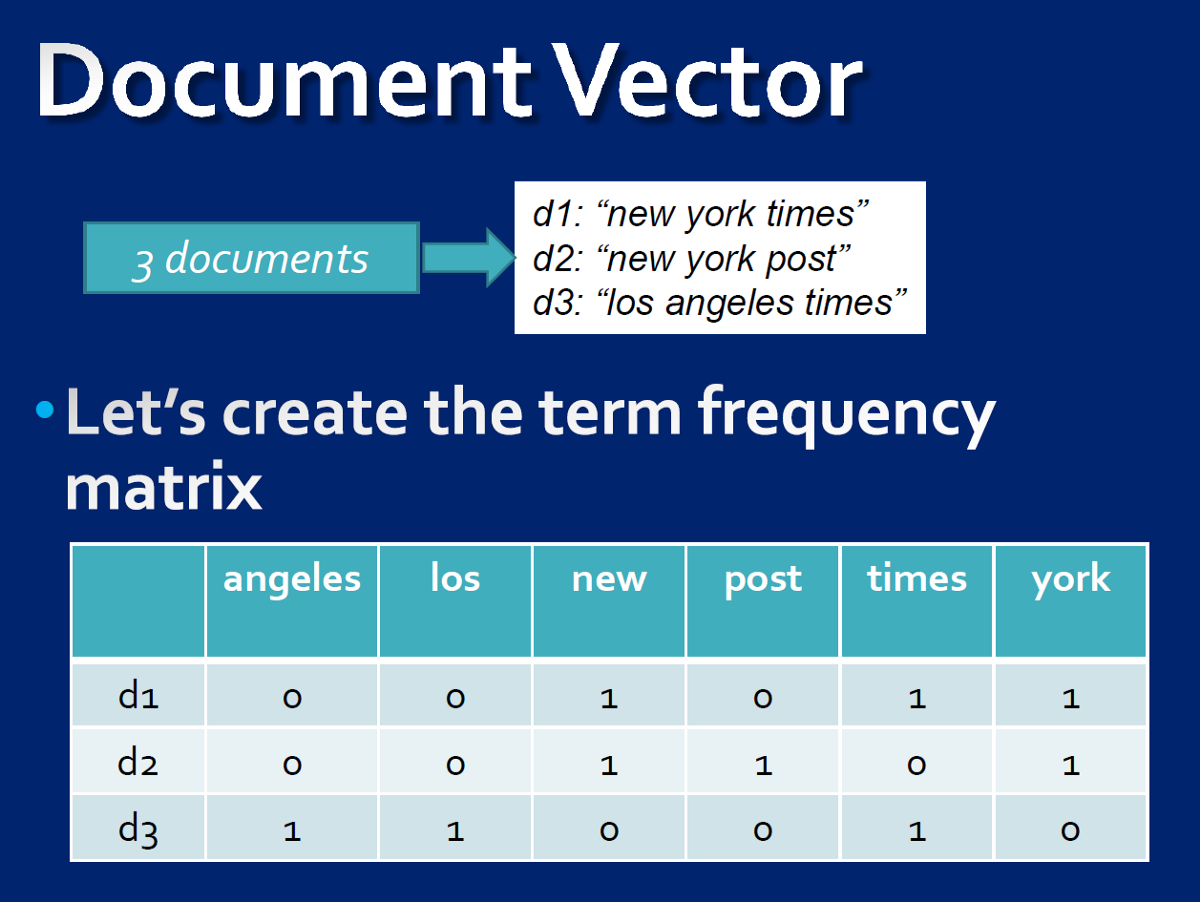

Source example: https://medium.com/@lifan0029820/coursera-big-data-specialization-course2-week3-4b7fa95cec5a

It takes the unique words and turns it into a column in the matrix. This is why turning them lowercase would be helpful now!

Constructing an inverse document frequency matrix: minimizing the impact of very common words such as "the". Thus, we are trying to make less-frequently seen words more meaningful in our search engine. 

Here is another example from the same source:
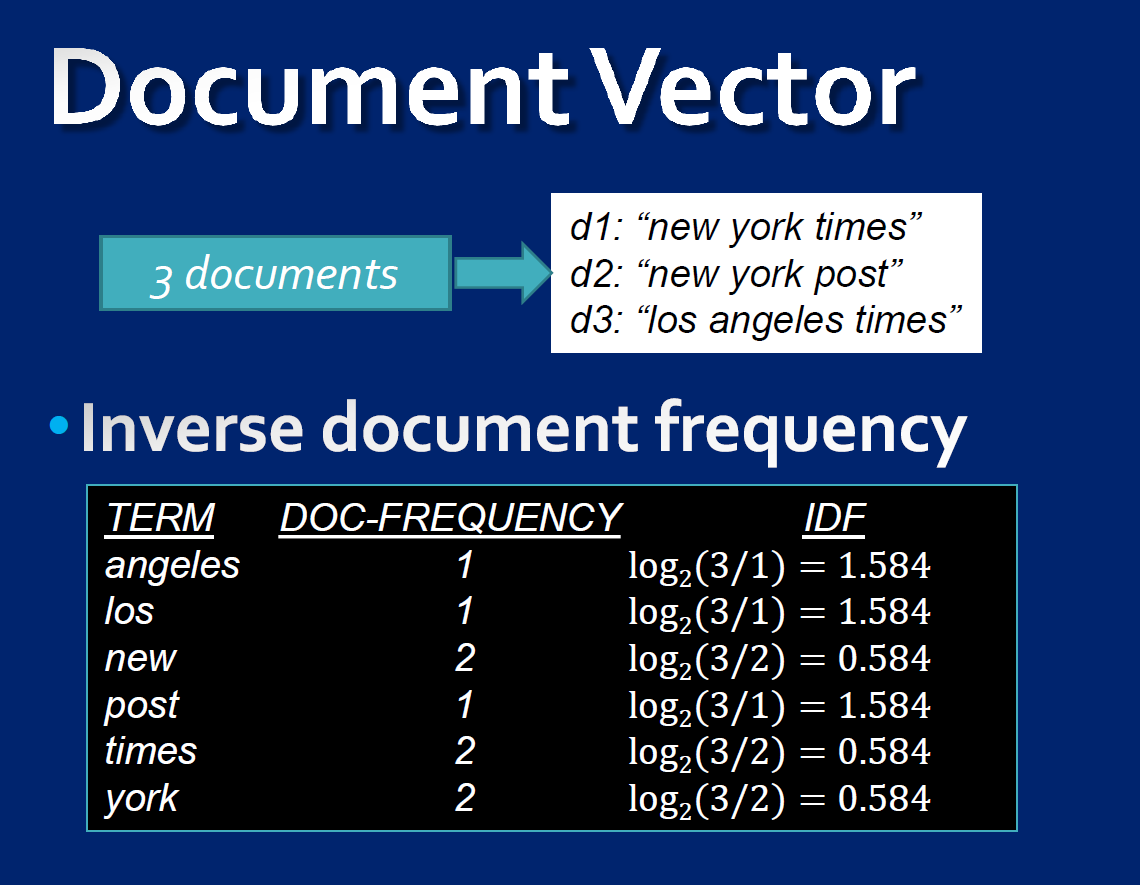

In our case: The log of the number of titles divided by the number of titles that that particular word appears in. 

Then we multiple those together to get our term frequency inverse document frequency matrix. Once again here is an example provided below (from the same source once again)

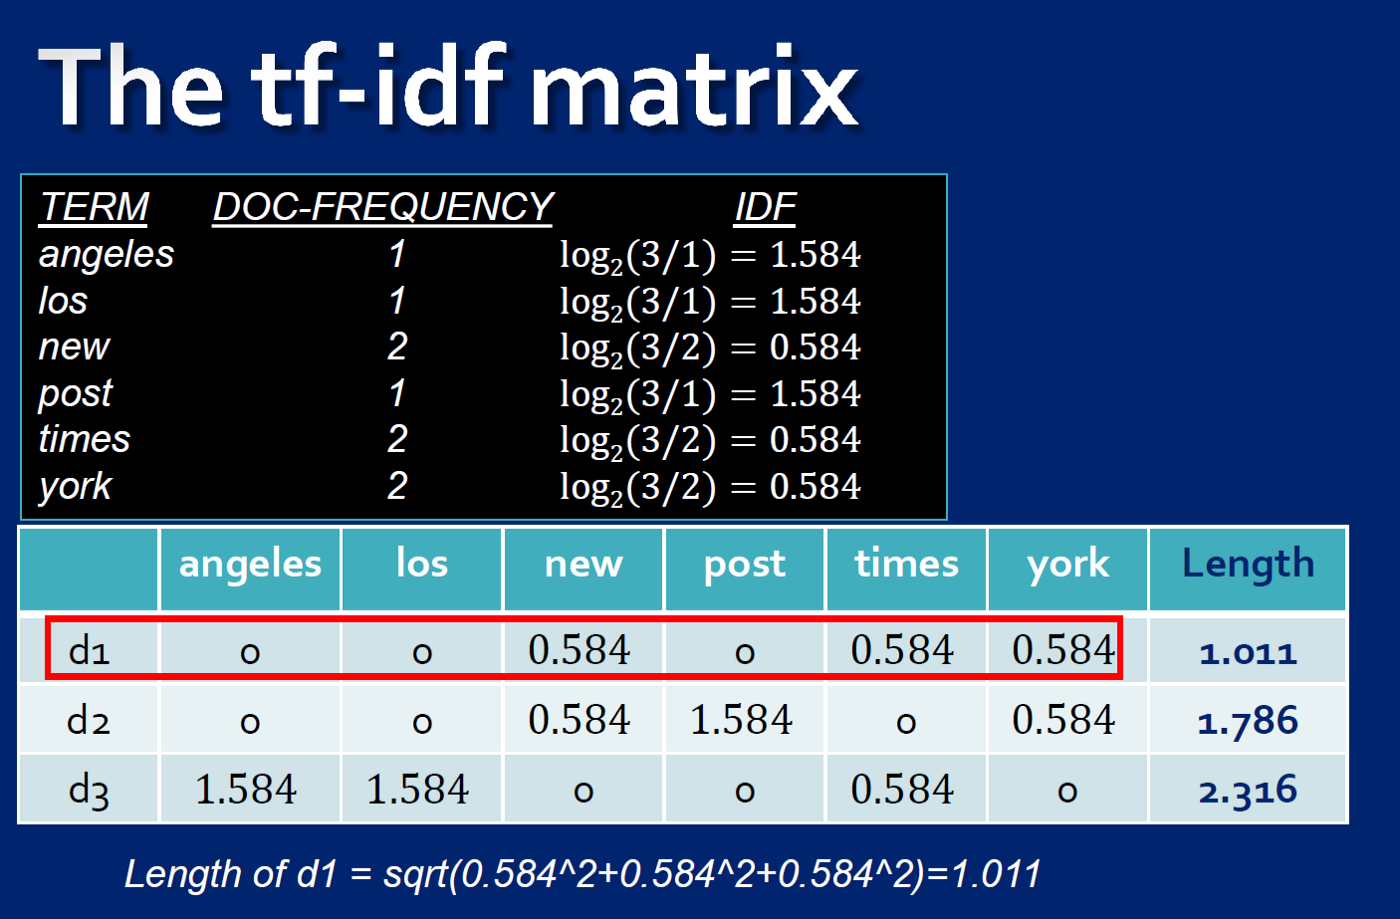

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tfidf = vectorizer.fit_transform(titles["mod_title"])

In [24]:
# Building the search engine!
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

# We are gonna style this column by building an HTML element for each of the columns. Style methods in Pandas!
def make_clickable(val):
    return '<a target="_blank" href="{}">Goodreads</a>'.format(val)

def show_image(val):
    return '<img src="{}" width=50></img>'.format(val)

def search(query, vectorizer):
    processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
    query_vec = vectorizer.transform([processed])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -10)[-10:] # Finding the 10 largest similarity types. Finding the indices!
    results = titles.iloc[indices] # Using the indices to find the type
    results = results.sort_values("ratings", ascending=False)
    return results.head(5).style.format({'url': make_clickable, 
                                         'cover_image': show_image}) #Returning top results

In [30]:
# With the book_id we can make a list of liked books
search("song of achilles", vectorizer)

,book_id,title,ratings,url,cover_image,mod_title
435078,11250317,The Song of Achilles,48003,Goodreads,,the song of achilles
1224382,13537029,The Song of Achilles,3159,Goodreads,,the song of achilles
512503,13516154,The Song of Achilles,2306,Goodreads,,the song of achilles
396822,11887641,The Song of Achilles,1187,Goodreads,,the song of achilles
689392,12501590,The Song of Achilles,951,Goodreads,,the song of achilles


# Creating a List of Liked Books

In [20]:
liked_books = ["53732", "117902", "472331", "6066095", "3850639", "526270", "11250317"]

# Exploring Book Rating Data